#### Imports

In [37]:
import sys
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from findmaxima2d import find_maxima, find_local_maxima
from scipy.ndimage import binary_erosion, binary_dilation

In [6]:
sys.path.append(r"C:\Users\97254\Desktop\git\MS2")

In [25]:
from cell_tracking import get_masks_paths
from src.utils.image_utils import enhance_cell_image_contrast



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.5.dev16+g79b0fcb 
platform:       	win32 
python version: 	3.10.13 
torch version:  	2.5.1+cu121! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




#### Functions

In [ ]:
def draw_cell_outlines_from_3d_mask(
    mask_3d: np.ndarray,
    image_2d: np.ndarray,
    line_width: int = 1,
    random_colors: bool = False,
    alpha: float = 1.0,
    background_label: int = 0,
    return_outline_only: bool = False,
):
    """
    Overlay 3D cell mask outlines (z,y,x) onto a 2D image (e.g. z-projection).

    Steps:
      1. For each cell label (excluding background) create a max projection.
      2. Extract its 2D outline via erosion XOR.
      3. Optionally assign a random color per label.
      4. Composite onto an RGB copy of the input image.

    Parameters
    ----------
    mask_3d : np.ndarray
        Integer-labeled mask of shape (Z, Y, X).
    image_2d : np.ndarray
        Grayscale 2D image (Y, X) used as background.
    line_width : int
        Thickness of outline (>=1).
    random_colors : bool
        If True, each label gets a random RGB color; else all outlines red.
    alpha : float
        Blend factor for outline color (0..1). 1 = solid outline.
    background_label : int
        Label value to ignore.
    return_outline_only : bool
        If True return (outline_mask, per_label_outline_dict) instead of RGB image.

    Returns
    -------
    overlay : np.ndarray
        (Y, X, 3) RGB image with outlines (unless return_outline_only=True).
    """
    if mask_3d.ndim != 3:
        raise ValueError("mask_3d must be 3D (Z,Y,X)")
    if image_2d.ndim != 2:
        raise ValueError("image_2d must be 2D (Y,X)")

    labels = np.unique(mask_3d)
    labels = labels[labels != background_label]

    # Prepare base image as float RGB
    img = image_2d.astype(np.float32)
    if img.max() > 0:
        norm = img / img.max()
    else:
        norm = img
    rgb = np.dstack([norm, norm, norm])

    full_outline = np.zeros(image_2d.shape, dtype=bool)
    per_label_outlines = {}

    rng = np.random.default_rng(42)

    for lab in labels:
        cell_stack = (mask_3d == lab)
        proj = cell_stack.max(axis=0)  # 2D projection of this cell
        if not proj.any():
            continue
        eroded = binary_erosion(proj, iterations=1, border_value=0)
        outline = proj ^ eroded
        if line_width > 1:
            outline = binary_dilation(outline, iterations=line_width - 1)
        per_label_outlines[int(lab)] = outline
        full_outline |= outline

        if random_colors:
            color = rng.random(3)
        else:
            color = np.array([1.0, 0.0, 0.0])  # red

        # Blend only where this label outline is
        oidx = outline
        if alpha >= 1.0:
            rgb[oidx] = color
        else:
            rgb[oidx] = (1 - alpha) * rgb[oidx] + alpha * color

    if return_outline_only:
        return full_outline, per_label_outlines
    return (rgb * 255).astype(np.uint8)

In [ ]:
def save_z_projection(ms2_z_projections, masks_paths, output_dir, prominence=18):
    for timepoint in range(ms2_z_projections.shape[0]):
        ms2_z_projections_t = ms2_z_projections[timepoint]
        masks_t = np.load(masks_paths[timepoint])['masks']
        local_max = find_local_maxima(ms2_z_projections_t)
        y, x, regs = find_maxima(ms2_z_projections_t, local_max, prominence)

#### Inputs

In [12]:
# paths
seg_masks_dir = r'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\segmentation\\masks'
ms2_filtered_z_projection = r'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\data\\czi_files\\SUM_C1-gRNA2_12.03.25-st-13-II---_ms2_channel_background_sub_z_project_sum_slice.tif'

timepoint = 0

In [16]:
ms2_z_projections = tifffile.imread(ms2_filtered_z_projection)
ms2_z_projections.shape

(80, 1024, 1024)

In [11]:
masks_paths = get_masks_paths(seg_masks_dir)

In [17]:
ms2_z_projections_t = ms2_z_projections[timepoint]
masks_t = np.load(masks_paths[timepoint])['masks']

In [27]:
local_max = find_local_maxima(ms2_z_projections_t)
y, x, regs = find_maxima(ms2_z_projections_t, local_max, 18)

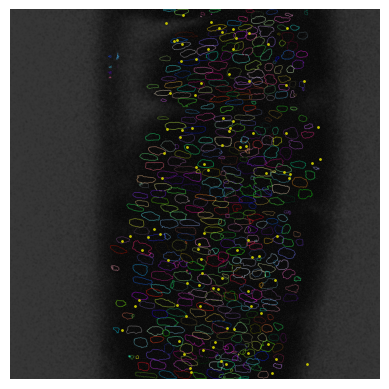

In [36]:
img_with_cell_outline = draw_cell_outlines_from_3d_mask(masks_t, ms2_z_projections_t, random_colors=True, alpha=1)
plt.imshow(img_with_cell_outline)
plt.scatter(x, y, c='y', s=1)
plt.axis('off')
plt.show()